Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: House Prices



## Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

Please follow the example above and call engine.dispose() when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.


In [34]:
import statsmodels.formula.api as smf


import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Investigate the data, and do any necessary data cleaning.


In [3]:
pd.set_option('display.max_columns', 500)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

First off, looking at the data description and seeing what would make sense to be highly correlated with sale price:
1. Lot area
2. OverallQual/cond
3. YearRemodAdd (negatively)
4. CentralAir
5. firstflrsf
6. secondflrsf (could make a dummy here for if it's not 0)
7. fullbath
8. bedroom
9. kitchen
10. kitchenqual
11. totroomsabovegrade
12. garagearea
13. WoodDeckSF
14. OpenPorchSF
15. EnclosedPorch (could make this a dummy)
16. three ssn portch (def dummy)

Dropping variables with many missing values:

In [4]:
df.miscfeature.isna().mean()

0.963013698630137

In [5]:
drop_cols=[]
for col in df.columns:
    if df[col].isna().mean()>.4:
        drop_cols=drop_cols+[col]
print(drop_cols)


['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature']


In [6]:
df_clean=df.drop(columns=drop_cols).dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1094 non-null   int64  
 1   mssubclass     1094 non-null   int64  
 2   mszoning       1094 non-null   object 
 3   lotfrontage    1094 non-null   float64
 4   lotarea        1094 non-null   int64  
 5   street         1094 non-null   object 
 6   lotshape       1094 non-null   object 
 7   landcontour    1094 non-null   object 
 8   utilities      1094 non-null   object 
 9   lotconfig      1094 non-null   object 
 10  landslope      1094 non-null   object 
 11  neighborhood   1094 non-null   object 
 12  condition1     1094 non-null   object 
 13  condition2     1094 non-null   object 
 14  bldgtype       1094 non-null   object 
 15  housestyle     1094 non-null   object 
 16  overallqual    1094 non-null   int64  
 17  overallcond    1094 non-null   int64  
 18  yearbuil

In [7]:
df_clean['secondflrexists']=0
df_clean.loc[df['secondflrsf']>0,'secondflrexists']=1 #can prob drop 2nd fl sq ft
df_clean.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,secondflrexists
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,1
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,1


In [43]:
# New variables
df_clean['totalsf']=df_clean['firstflrsf']=+df_clean['secondflrsf']
df_clean['yrsbltqared']=df_clean['yearbuilt']*df_clean['yearbuilt']


In [8]:
df_clean.masvnrtype.value_counts()

None       639
BrkFace    327
Stone      119
BrkCmn       9
Name: masvnrtype, dtype: int64

In [12]:
#sns.pairplot(data=df_clean,y_vars=['saleprice'],x_vars=['lotarea', 'height', 'happiness'])
#df_clean.head()

## Explore the data and find some variables that you think would be useful in predicting house prices. ##


In [13]:
y=df_clean['saleprice']
X=df_clean.drop(columns=['saleprice','id'])

In [14]:
X.mszoning.dtype==int

False

In [15]:
cat_cols=[c for c in X.columns if X[c].dtype=='O']
numeric_cols=[c for c in X.columns if X[c].dtype!='O']

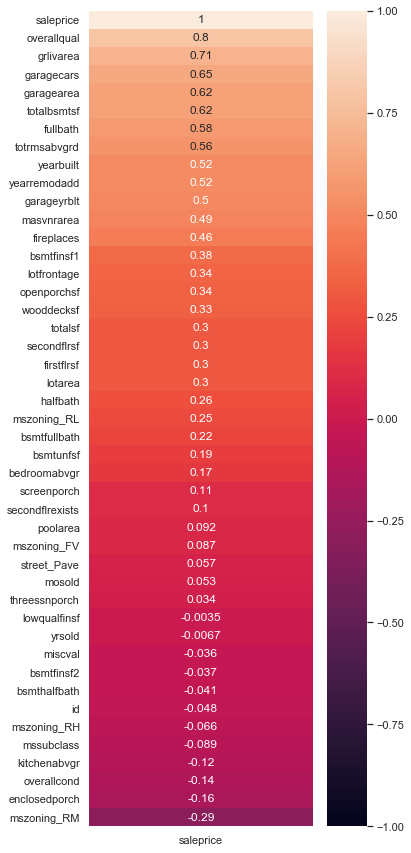

In [38]:
df_corrs = df_clean.corr()[["saleprice"]].sort_values("saleprice", ascending=False)

sns.set(rc={'figure.figsize':(5,15)})
sns.heatmap(df_corrs, vmin=-1, vmax=1, annot=True)
plt.show()

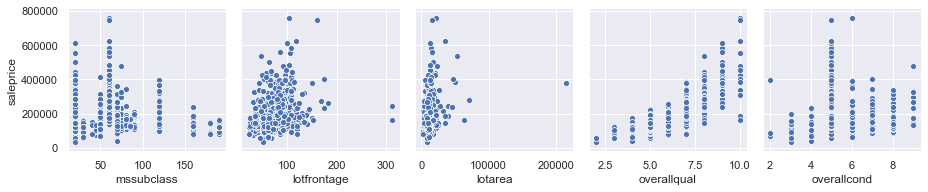

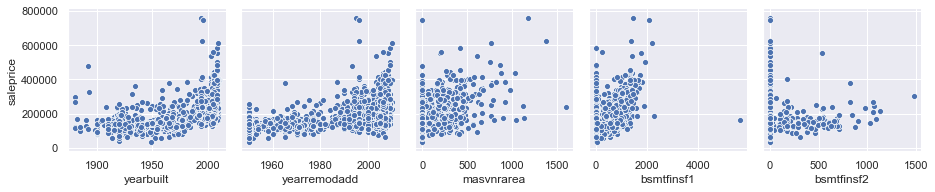

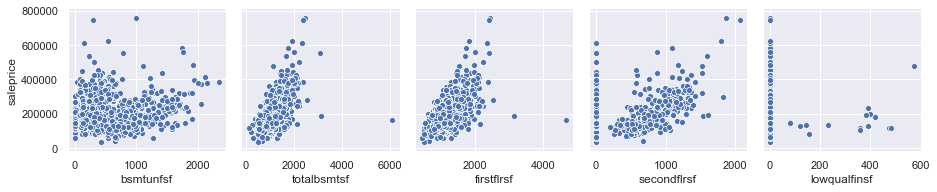

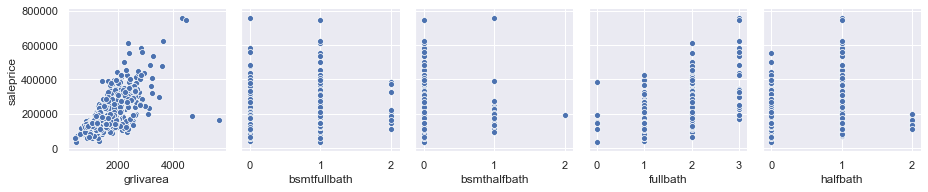

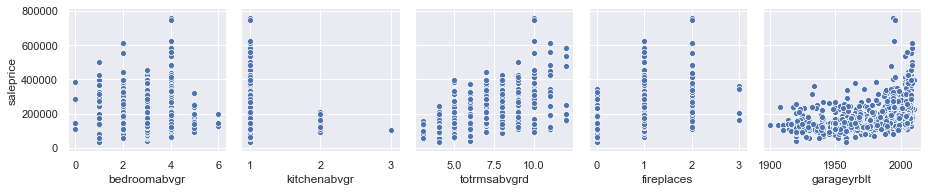

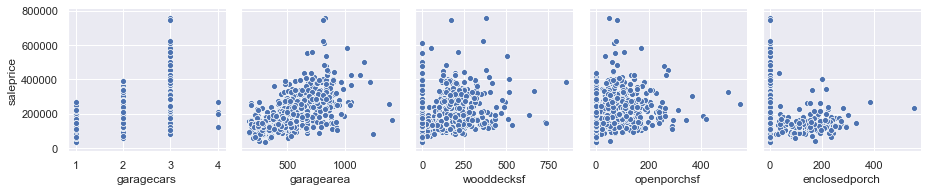

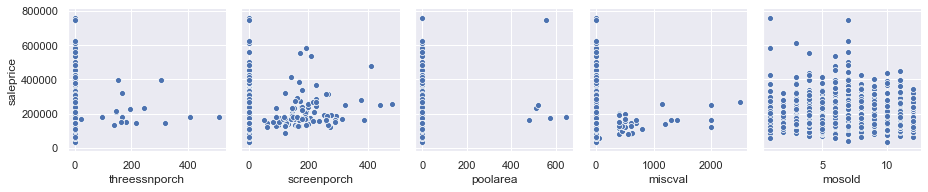

In [17]:
x=0
while x+5<len(numeric_cols):
    sns.pairplot(data=df_clean,y_vars=['saleprice'],x_vars=numeric_cols[x:x+5])
    #plt.xticks(rotation=45)
    plt.show()
    x=x+5


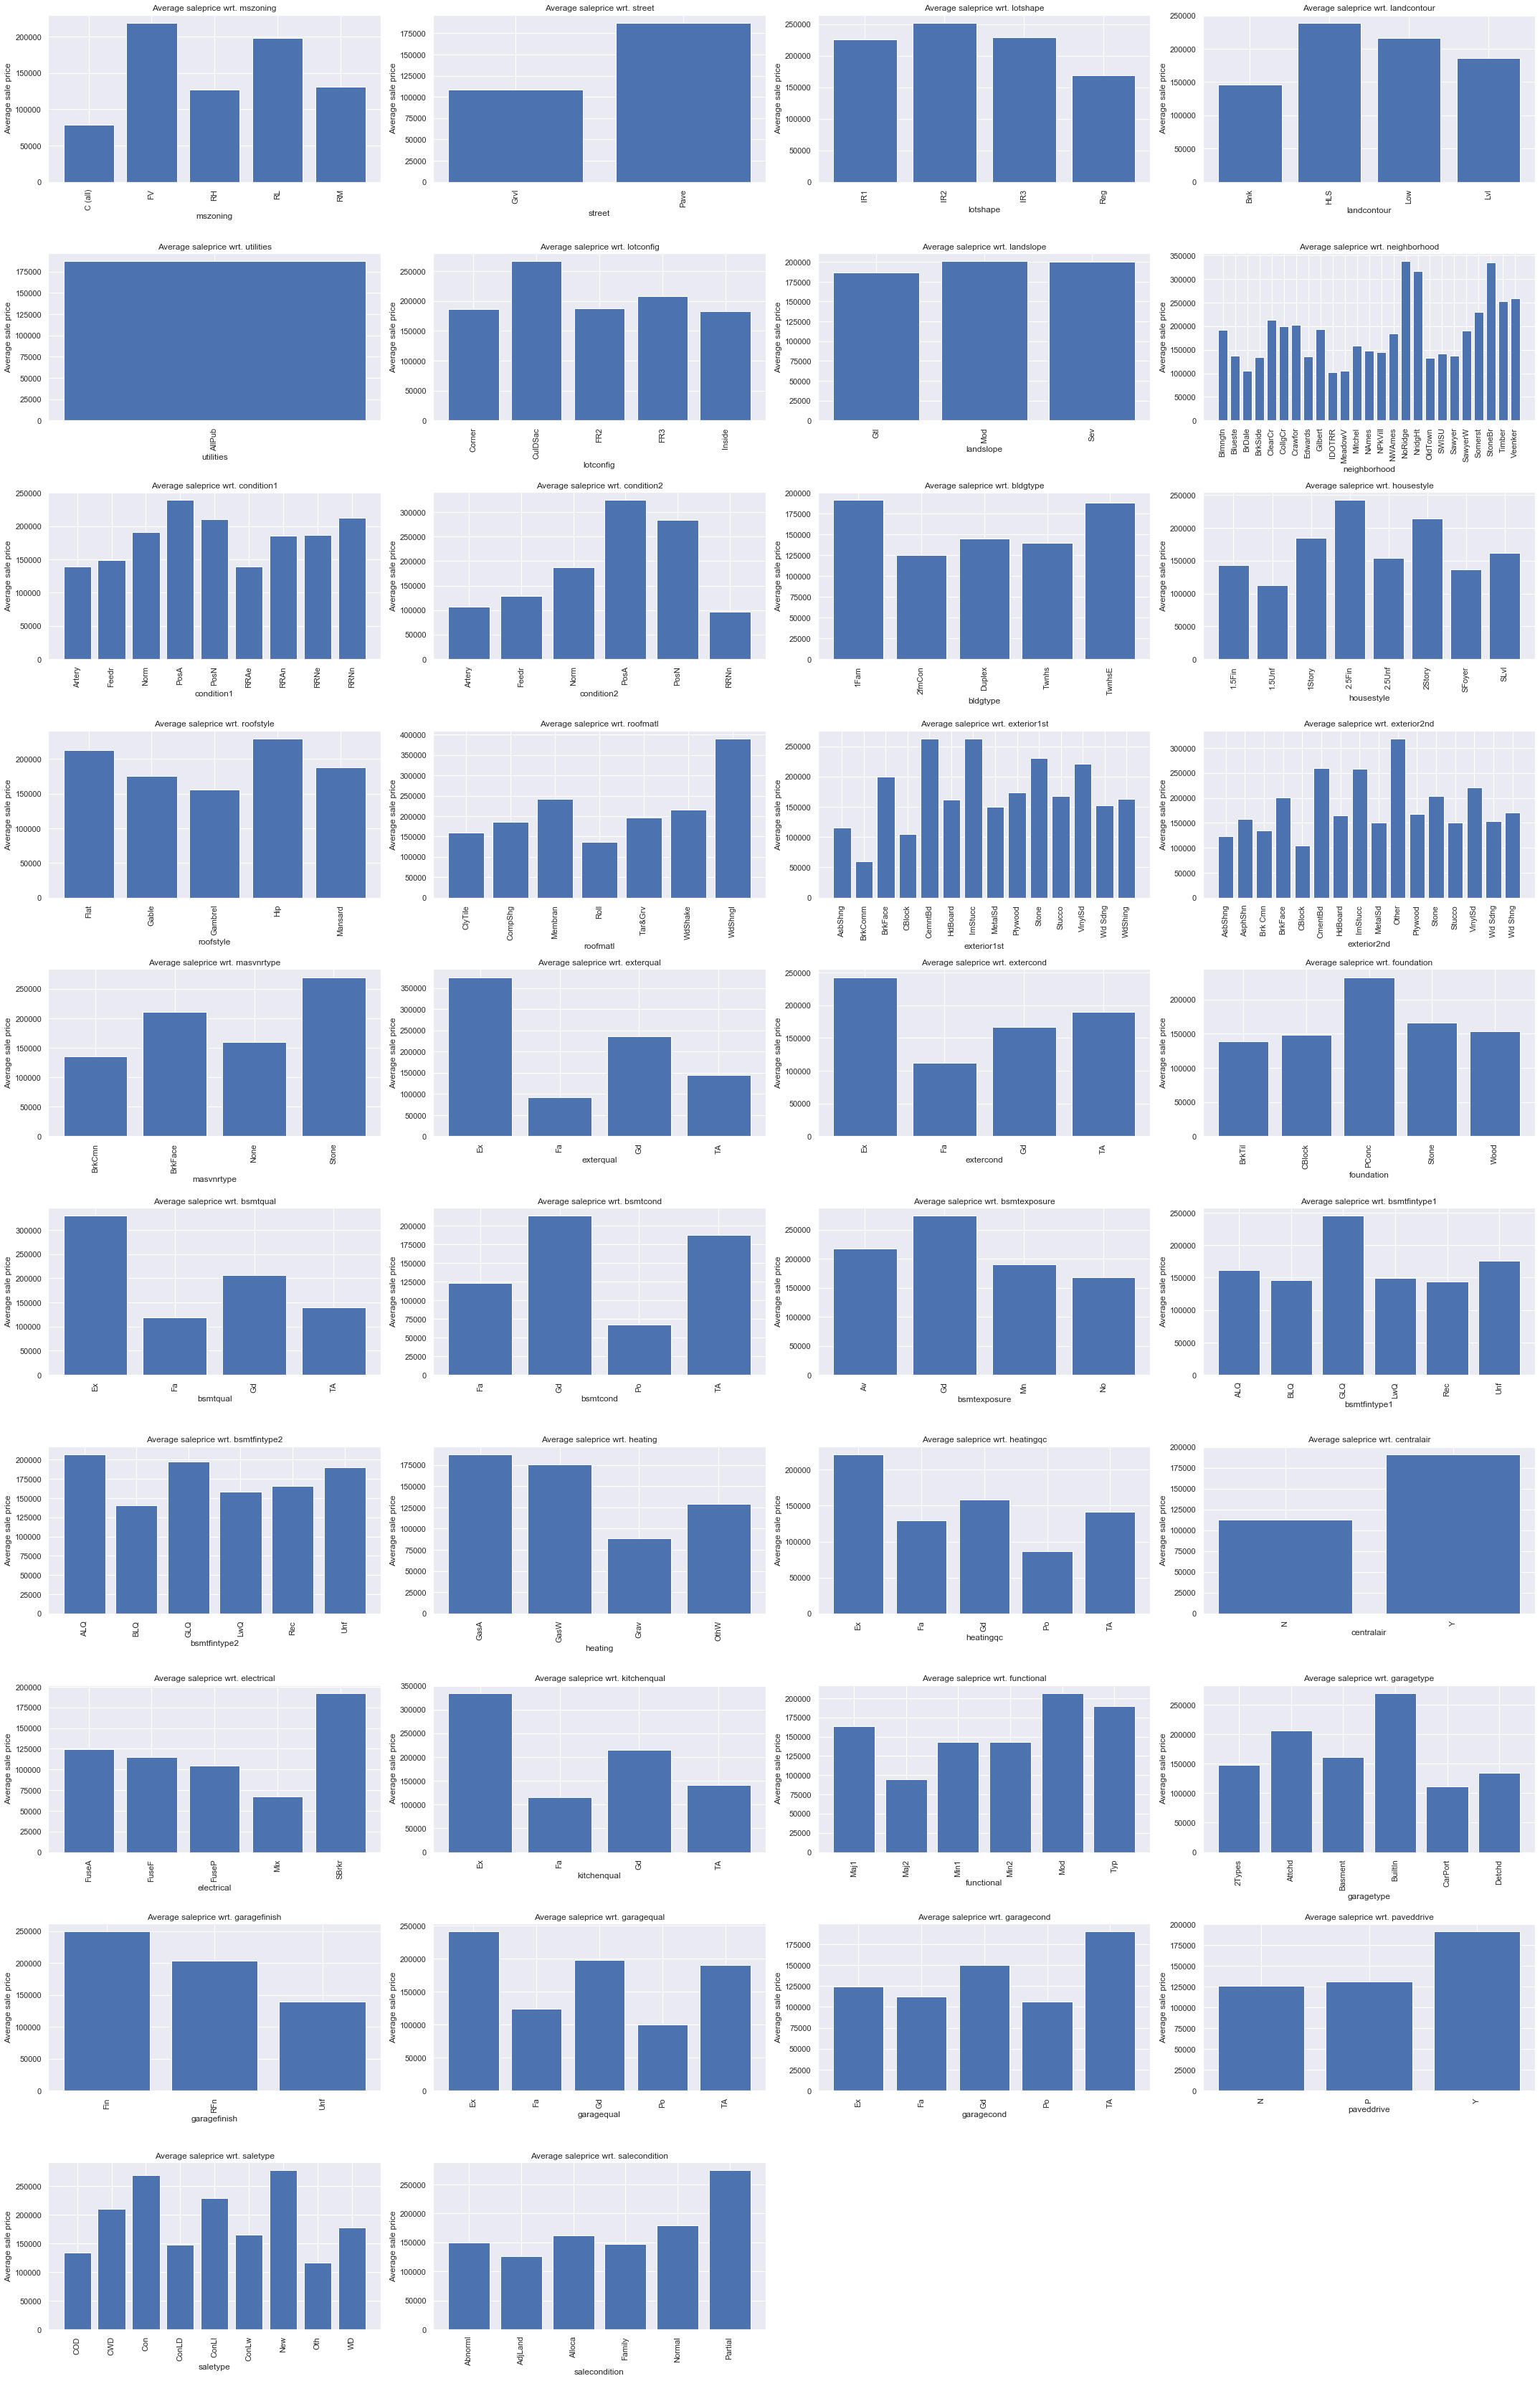

In [18]:
plt.figure(figsize=(30,50))

for index, column in enumerate(cat_cols):
    plt.subplot(11,4,index+1)
    plt.bar(df_clean.groupby(column)["saleprice"].mean().index, df_clean.groupby(column)["saleprice"].mean(),
           )
    plt.title(f"Average saleprice wrt. {column}")
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()


In [57]:
df_clean.groupby(by=neighborhood)

NAmes      173
CollgCr    122
OldTown     96
Somerst     75
NridgHt     74
Edwards     65
Gilbert     49
NWAmes      45
Sawyer      44
SawyerW     44
BrkSide     42
Crawfor     41
NoRidge     33
Mitchel     30
Timber      29
IDOTRR      27
StoneBr     20
SWISU       19
BrDale      15
Blmngtn     14
ClearCr     11
MeadowV     10
Veenker      7
NPkVill      7
Blueste      2
Name: neighborhood, dtype: int64

In [19]:

df_clean = pd.concat([df_clean,pd.get_dummies(df_clean.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df_clean = pd.concat([df_clean,pd.get_dummies(df_clean.street, prefix="street", drop_first=True)], axis=1)


dummy_column_names = list(pd.get_dummies(df_clean.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df_clean.street, prefix="street", drop_first=True).columns)


In [58]:
niceneighborhoods=['NridgHt', 'NoRidge', 'Somerst', 'Timber', 'Veenker', 'StoneBr']
df_clean['nicehood']=0
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'nicehood']=1


## Build your initial model using these features and estimate the parameters using OLS.


In [63]:
import statsmodels.api as sm

X = df_clean[['overallqual','grlivarea', 'garagearea', 'totalbsmtsf','yearremodadd','yearbuilt','yrsbltqared','lotarea','nicehood']]
Y = df_clean.saleprice

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     440.4
Date:                Tue, 01 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:09:20   Log-Likelihood:                -13104.
No. Observations:                1094   AIC:                         2.623e+04
Df Residuals:                    1084   BIC:                         2.628e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -2.15e+07   5.77e+06     -3.723   

In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1094 non-null   int64  
 1   mssubclass       1094 non-null   int64  
 2   mszoning         1094 non-null   object 
 3   lotfrontage      1094 non-null   float64
 4   lotarea          1094 non-null   int64  
 5   street           1094 non-null   object 
 6   lotshape         1094 non-null   object 
 7   landcontour      1094 non-null   object 
 8   utilities        1094 non-null   object 
 9   lotconfig        1094 non-null   object 
 10  landslope        1094 non-null   object 
 11  neighborhood     1094 non-null   object 
 12  condition1       1094 non-null   object 
 13  condition2       1094 non-null   object 
 14  bldgtype         1094 non-null   object 
 15  housestyle       1094 non-null   object 
 16  overallqual      1094 non-null   int64  
 17  overallcond   

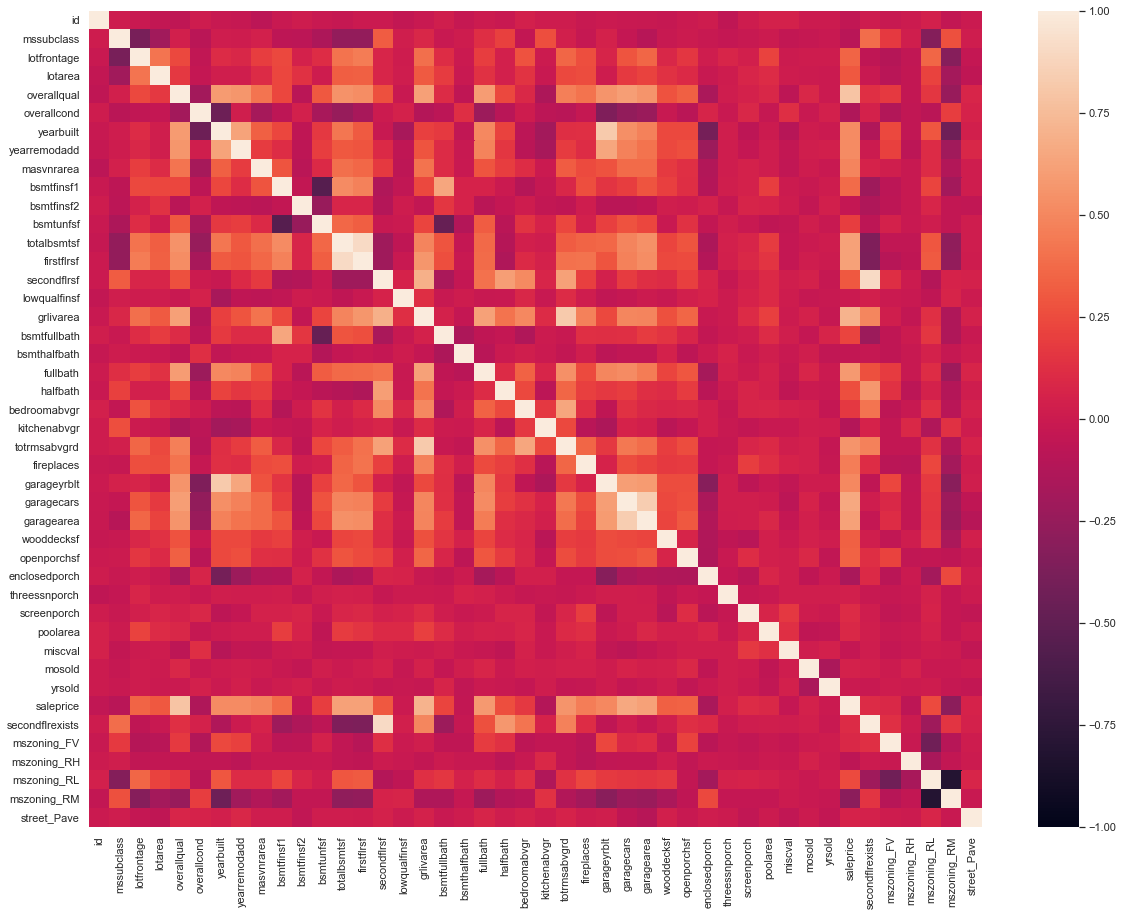

In [32]:
corrs2=df_clean.corr()
sns.set(rc={'figure.figsize':(20,15)})

sns.heatmap(corrs2, vmin=-1, vmax=1, annot=False)


In [33]:
corrs2

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,secondflrexists,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
id,1.000000,0.015540,-0.014479,-0.042315,-0.058371,0.008627,-0.022610,-0.030239,-0.072344,-0.013234,0.014964,-0.014316,-0.024541,-0.007492,-0.005997,-0.040553,-0.013772,0.027265,-0.027415,0.003601,-0.015403,0.039320,0.013252,0.013832,-0.015798,-0.003820,-0.009568,-0.023290,-0.027597,-0.000987,0.011796,-0.061688,0.015019,0.048487,0.050954,0.007486,0.005307,-0.047595,0.011535,-0.021795,0.003959,0.046815,-0.039356,-0.007324
mssubclass,0.015540,1.000000,-0.389466,-0.197903,0.031639,-0.085553,0.021605,0.010178,0.040009,-0.069439,-0.073834,-0.147155,-0.264277,-0.258207,0.319176,0.024935,0.078213,-0.013040,0.012509,0.119495,0.206259,-0.044628,0.258401,0.038180,-0.029575,0.051225,-0.031638,-0.095374,-0.018514,0.006799,-0.019313,-0.035855,-0.021854,0.003221,-0.043299,-0.025393,-0.012347,-0.089478,0.383398,0.171883,0.028904,-0.334657,0.270763,0.023287
lotfrontage,-0.014479,-0.389466,1.000000,0.419714,0.241169,-0.047132,0.107958,0.082938,0.189769,0.239734,0.046928,0.111368,0.407566,0.453035,0.074953,0.010748,0.397260,0.115151,-0.000491,0.189692,0.043414,0.277136,0.007411,0.354714,0.260293,0.067254,0.285748,0.357030,0.081338,0.160862,0.016058,0.073004,0.034937,0.211959,0.000789,0.014951,0.013366,0.343978,-0.054710,-0.107660,-0.047850,0.354084,-0.324730,-0.038923
lotarea,-0.042315,-0.197903,0.419714,1.000000,0.169876,-0.033113,0.028954,0.024308,0.106600,0.232341,0.138615,0.008924,0.324476,0.331295,0.075311,0.019956,0.308590,0.179874,-0.014597,0.132860,0.043977,0.141428,-0.010855,0.241849,0.255842,0.012871,0.173525,0.213104,0.133995,0.098051,-0.022789,0.013343,0.072413,0.109294,0.012483,0.006270,-0.006412,0.302268,-0.009451,-0.088790,-0.041100,0.215211,-0.181918,-0.054958
overallqual,-0.058371,0.031639,0.241169,0.169876,1.000000,-0.189587,0.590761,0.568582,0.419756,0.230438,-0.081342,0.297384,0.547448,0.527908,0.265906,-0.011186,0.610102,0.107138,-0.060775,0.597881,0.239893,0.091462,-0.141071,0.465733,0.409725,0.562405,0.605466,0.555315,0.273652,0.335884,-0.155080,0.020081,0.049286,0.080037,-0.062944,0.082995,-0.003529,0.795437,0.127759,0.174895,-0.046143,0.158224,-0.239956,0.077496
overallcond,0.008627,-0.085553,-0.047132,-0.033113,-0.189587,1.000000,-0.437647,0.024427,-0.174581,-0.068285,0.040598,-0.169743,-0.243419,-0.166191,0.004047,0.047865,-0.115250,-0.072778,0.121421,-0.225995,-0.089625,0.012300,-0.070660,-0.093309,-0.030731,-0.353291,-0.269616,-0.233585,-0.018856,-0.084405,0.067124,-0.010881,0.084416,-0.024919,0.121407,-0.009661,0.046775,-0.138511,0.052997,-0.119137,-0.049200,-0.083399,0.191238,0.061138
yearbuilt,-0.022610,0.021605,0.107958,0.028954,0.590761,-0.437647,1.000000,0.625905,0.328897,0.234207,-0.058987,0.170077,0.423763,0.311928,-0.021327,-0.165742,0.198778,0.179631,-0.051070,0.501806,0.215519,-0.072816,-0.188032,0.117850,0.128739,0.824156,0.533258,0.470809,0.236512,0.235486,-0.399540,0.030743,-0.065413,0.006402,-0.098054,0.014127,-0.003639,0.523434,-0.132499,0.236700,-0.052167,0.292695,-0.431553,0.037235
yearremodadd,-0.030239,0.010178,0.082938,0.024308,0.568582,0.024427,0.625905,1.000000,0.187492,0.111675,-0.063813,0.187505,0.302488,0.286565,0.096666,-0.055626,0.287412,0.104034,-0.020028,0.481361,0.156398,-0.083789,-0.164620,0.182860,0.113930,0.648282,0.473753,0.413917,0.240775,0.259469,-0.220843,0.020567,-0.038039,0.018813,-0.040388,0.031242,0.037684,0.519806,0.001476,0.209471,-0.077994,0.108261,-0.200149,0.083727
masvnrarea,-0.072344,0.040009,0.189769,0.106600,0.419756,-0.174581,0.328897,0.187492,1.000000,0.281356,-0.080799,0.100304,0.3

In [ ]:
print_vif(df_clean)

In [60]:
df_clean.nicehood.value_counts()

0    856
1    238
Name: nicehood, dtype: int64